In [7]:
import colour
from skimage.color import deltaE_cie76, rgb2lab  # Import from skimage


In [20]:
import numpy as np
from PIL import Image
import numpy as np
from PIL import Image
import random
import numpy as np
from PIL import Image
import random
from copy import copy
from operator import attrgetter
from random import randint, sample, choice, uniform
from math import exp

image = Image.open('target_image.jpg').convert('RGB')

new_width=150
new_height=100

target_image = image.resize((new_width, new_height), Image.ANTIALIAS)

target_array = np.array(target_image)


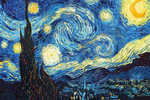

In [21]:
target_image

In [22]:
import numpy as np

# Check if target_array has any None values
has_none_values = np.isnan(target_array).any()

if has_none_values:
    print("The target_array contains None values.")
else:
    print("The target_array does not contain None values.")


The target_array does not contain None values.


In [23]:
target_array

array([[[ 41,  53, 104],
        [ 20,  26,  61],
        [ 33,  31,  49],
        ...,
        [162, 173, 115],
        [ 67, 104, 104],
        [162, 189, 175]],

       [[ 61,  74, 126],
        [ 44,  49,  88],
        [ 31,  24,  49],
        ...,
        [211, 226, 124],
        [166, 175, 136],
        [ 83, 145, 164]],

       [[ 56,  77, 130],
        [ 41,  47,  92],
        [ 36,  28,  64],
        ...,
        [150, 168, 109],
        [197, 212, 119],
        [197, 223, 106]],

       ...,

       [[ 28,  27,  42],
        [ 27,  30,  48],
        [ 29,  32,  51],
        ...,
        [ 31,  15,  30],
        [ 31,  15,  31],
        [ 35,  19,  35]],

       [[ 27,  24,  37],
        [ 23,  25,  43],
        [ 20,  26,  49],
        ...,
        [ 31,  21,  31],
        [ 30,  22,  32],
        [ 24,  18,  28]],

       [[ 35,  30,  42],
        [ 24,  23,  40],
        [ 24,  29,  52],
        ...,
        [ 31,  20,  32],
        [ 29,  19,  30],
        [ 35,  27,  38]]

In [53]:
class Individual:
    def __init__(self, representation=None):
        self.representation = representation
        self.fitness = self.get_fitness()

    def get_fitness(self):
        raise NotImplementedError("You need to implement the get_fitness method.")

class ColorIndividual(Individual):
    def __init__(self, representation=None, target_array=None):
        if representation is None:
            self.representation = np.random.randint(0, 256, target_array.shape, dtype=np.uint8)
        else:
            self.representation = np.array(representation, dtype=np.uint8)
        self.fitness = self.get_fitness(target_array)

    def get_fitness(self, target_array):
        return np.sum((self.representation - target_array) ** 2)
        
def mutation(individual, mutation_rate):
    mutated_repr = individual.representation.copy()
    for i in range(mutated_repr.shape[0]):
        for j in range(mutated_repr.shape[1]):
            if random.random() < mutation_rate:
                mutated_repr[i, j] = np.random.randint(0, 256, 3)
    return ColorIndividual(representation=mutated_repr, target_array=target_array)

def crossover(parent1_repr, parent2_repr):
    point = random.randint(0, parent1_repr.shape[0] - 1)
    child1_repr = np.concatenate((parent1_repr[:point], parent2_repr[point:]), axis=0)
    child2_repr = np.concatenate((parent2_repr[:point], parent1_repr[point:]), axis=0)
    return child1_repr, child2_repr


In [54]:
class Population:
    def __init__(self, size, optim):
        self.size = size
        self.optim = optim
        self.individuals = []

    def evolve(self, gens, xo_prob, mut_prob, select, xo, mutate, elitism):
        for i in range(gens):
            new_pop = []
            if elitism:
                elite = copy(min(self.individuals, key=attrgetter('fitness')))

            while len(new_pop) < self.size:
                parent1, parent2 = select(self), select(self)
                if random.random() < xo_prob:
                    offspring1_repr, offspring2_repr = xo(parent1.representation, parent2.representation)
                else:
                    offspring1_repr, offspring2_repr = parent1.representation, parent2.representation

                if random.random() < mut_prob:
                    offspring1_repr = mutate(ColorIndividual(representation=offspring1_repr, target_array=target_array), mut_prob).representation
                if random.random() < mut_prob:
                    offspring2_repr = mutate(ColorIndividual(representation=offspring2_repr, target_array=target_array), mut_prob).representation

                new_pop.append(ColorIndividual(representation=offspring1_repr, target_array=target_array))
                if len(new_pop) < self.size:
                    new_pop.append(ColorIndividual(representation=offspring2_repr, target_array=target_array))

            if elitism:
                worst = max(new_pop, key=attrgetter('fitness'))
                if elite.fitness < worst.fitness:
                    new_pop.pop(new_pop.index(worst))
                    new_pop.append(elite)

            self.individuals = new_pop
            print(f"Best fitness of gen #{i + 1}: {min(self.individuals, key=attrgetter('fitness')).fitness}")

    def __len__(self):
        return len(self.individuals)

    def __getitem__(self, position):
        return self.individuals[position]

class ColorPopulation(Population):
    def __init__(self, size, optim, target_array, **kwargs):
        super().__init__(size, optim)
        self.target_array = target_array
        self.individuals = [ColorIndividual(target_array=target_array) for _ in range(size)]


In [55]:
population_size = 100
mutation_rate = 0.01
generations = 1000
xo_prob = 0.7
elitism = True

population = ColorPopulation(size=population_size, optim="min", target_array=target_array)

def tournament_sel(population, tour_size=3):
    tournament = [choice(population) for _ in range(tour_size)]
    return min(tournament, key=attrgetter('fitness'))

def selection(pop):
    return tournament_sel(pop, tour_size=3)

population.evolve(
    gens=generations,
    xo_prob=xo_prob,
    mut_prob=mutation_rate,
    select=selection,
    xo=crossover,
    mutate=lambda ind, mut_rate: mutation(ind, mut_rate),
    elitism=elitism
)
best_individual = min(population.individuals, key=attrgetter('fitness')).representation
best_image = Image.fromarray(best_individual)


Best fitness of gen #1: 4690520
Best fitness of gen #2: 4685189
Best fitness of gen #3: 4682334
Best fitness of gen #4: 4682334
Best fitness of gen #5: 4682334
Best fitness of gen #6: 4675776
Best fitness of gen #7: 4675732
Best fitness of gen #8: 4672383
Best fitness of gen #9: 4669273
Best fitness of gen #10: 4663715
Best fitness of gen #11: 4662778
Best fitness of gen #12: 4660946
Best fitness of gen #13: 4657341
Best fitness of gen #14: 4654580
Best fitness of gen #15: 4652534
Best fitness of gen #16: 4649142
Best fitness of gen #17: 4647415
Best fitness of gen #18: 4646243
Best fitness of gen #19: 4642299
Best fitness of gen #20: 4641212
Best fitness of gen #21: 4639765
Best fitness of gen #22: 4636426
Best fitness of gen #23: 4635982
Best fitness of gen #24: 4632814
Best fitness of gen #25: 4632016
Best fitness of gen #26: 4632016
Best fitness of gen #27: 4629826
Best fitness of gen #28: 4628797
Best fitness of gen #29: 4628797
Best fitness of gen #30: 4627448
Best fitness of gen

Best fitness of gen #253: 4518384
Best fitness of gen #254: 4518384
Best fitness of gen #255: 4517489
Best fitness of gen #256: 4517417
Best fitness of gen #257: 4516981
Best fitness of gen #258: 4516744
Best fitness of gen #259: 4516663
Best fitness of gen #260: 4516020
Best fitness of gen #261: 4515873
Best fitness of gen #262: 4515147
Best fitness of gen #263: 4515046
Best fitness of gen #264: 4514969
Best fitness of gen #265: 4514822
Best fitness of gen #266: 4514510
Best fitness of gen #267: 4514362
Best fitness of gen #268: 4514207
Best fitness of gen #269: 4513636
Best fitness of gen #270: 4513366
Best fitness of gen #271: 4512480
Best fitness of gen #272: 4512285
Best fitness of gen #273: 4512285
Best fitness of gen #274: 4511632
Best fitness of gen #275: 4510535
Best fitness of gen #276: 4510535
Best fitness of gen #277: 4509740
Best fitness of gen #278: 4508720
Best fitness of gen #279: 4508564
Best fitness of gen #280: 4508148
Best fitness of gen #281: 4507424
Best fitness o

Best fitness of gen #498: 4426227
Best fitness of gen #499: 4426227
Best fitness of gen #500: 4426227
Best fitness of gen #501: 4426227
Best fitness of gen #502: 4426227
Best fitness of gen #503: 4422902
Best fitness of gen #504: 4422112
Best fitness of gen #505: 4422112
Best fitness of gen #506: 4422112
Best fitness of gen #507: 4421666
Best fitness of gen #508: 4421666
Best fitness of gen #509: 4421551
Best fitness of gen #510: 4421477
Best fitness of gen #511: 4421105
Best fitness of gen #512: 4421105
Best fitness of gen #513: 4420899
Best fitness of gen #514: 4420899
Best fitness of gen #515: 4420899
Best fitness of gen #516: 4420825
Best fitness of gen #517: 4420825
Best fitness of gen #518: 4420797
Best fitness of gen #519: 4420797
Best fitness of gen #520: 4420797
Best fitness of gen #521: 4420746
Best fitness of gen #522: 4420746
Best fitness of gen #523: 4420746
Best fitness of gen #524: 4420746
Best fitness of gen #525: 4418167
Best fitness of gen #526: 4418167
Best fitness o

Best fitness of gen #753: 4380396
Best fitness of gen #754: 4380396
Best fitness of gen #755: 4380396
Best fitness of gen #756: 4380396
Best fitness of gen #757: 4380396
Best fitness of gen #758: 4380396
Best fitness of gen #759: 4378633
Best fitness of gen #760: 4378633
Best fitness of gen #761: 4377315
Best fitness of gen #762: 4377315
Best fitness of gen #763: 4376939
Best fitness of gen #764: 4376939
Best fitness of gen #765: 4376894
Best fitness of gen #766: 4376894
Best fitness of gen #767: 4376801
Best fitness of gen #768: 4376660
Best fitness of gen #769: 4376476
Best fitness of gen #770: 4376418
Best fitness of gen #771: 4376226
Best fitness of gen #772: 4376226
Best fitness of gen #773: 4373846
Best fitness of gen #774: 4373846
Best fitness of gen #775: 4373322
Best fitness of gen #776: 4373260
Best fitness of gen #777: 4373260
Best fitness of gen #778: 4372949
Best fitness of gen #779: 4372427
Best fitness of gen #780: 4372427
Best fitness of gen #781: 4372116
Best fitness o

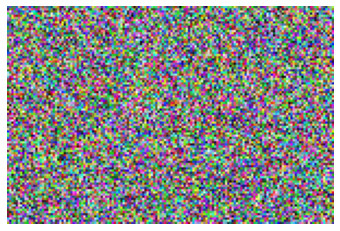

In [56]:
import matplotlib.pyplot as plt

# Assuming best_individual contains the pixel values of the best image
# Display the image using Matplotlib
plt.imshow(best_individual)
plt.axis('off')  # Turn off axis labels
plt.show()

In [14]:
import numpy as np
import random
from PIL import Image
from skimage.color import deltaE_cie76, rgb2lab
from copy import copy
from operator import attrgetter
from random import choice

class Individual:
    def __init__(self, representation=None):
        self.representation = representation
        self.fitness = self.get_fitness()

    def get_fitness(self):
        raise NotImplementedError("You need to implement the get_fitness method.")

class ColorIndividual(Individual):
    def __init__(self, representation=None, target_array=None):
        if representation is None:
            self.representation = np.random.randint(0, 256, target_array.shape, dtype=np.uint8)
        else:
            self.representation = np.array(representation, dtype=np.uint8)
        self.target_array = target_array
        self.array = self.representation  # Assuming self.array is a representation of the image
        self.fitness = self.get_fitness_euclidean(target_array)

    def get_fitness_euclidean(self, target_array):
        # Convert RGB images to Lab color space for better perceptual accuracy
        target_lab = rgb2lab(target_array)
        array_lab = rgb2lab(self.array)
        diff_array = deltaE_cie76(target_lab, array_lab)
        self.fitness = np.mean(diff_array)
        return self.fitness

def mutation(individual, mutation_rate):
    mutated_repr = individual.representation.copy()
    for i in range(mutated_repr.shape[0]):
        for j in range(mutated_repr.shape[1]):
            if random.random() < mutation_rate:
                shift = np.random.randint(-20, 20, 3)
                mutated_repr[i, j] = np.clip(mutated_repr[i, j] + shift, 0, 255)
    return ColorIndividual(representation=mutated_repr, target_array=individual.target_array)

def crossover(parent1_repr, parent2_repr):
    point = random.randint(0, parent1_repr.shape[0] - 1)
    child1_repr = np.concatenate((parent1_repr[:point], parent2_repr[point:]), axis=0)
    child2_repr = np.concatenate((parent2_repr[:point], parent1_repr[point:]), axis=0)
    return child1_repr, child2_repr

class Population:
    def __init__(self, size, optim):
        self.size = size
        self.optim = optim
        self.individuals = []

    def evolve(self, gens, xo_prob, mut_prob, select, xo, mutate, elitism):
        for i in range(gens):
            new_pop = []
            if elitism:
                elite = copy(min(self.individuals, key=attrgetter('fitness')))

            while len(new_pop) < self.size:
                parent1, parent2 = select(self), select(self)
                if random.random() < xo_prob:
                    offspring1_repr, offspring2_repr = xo(parent1.representation, parent2.representation)
                else:
                    offspring1_repr, offspring2_repr = parent1.representation, parent2.representation

                if random.random() < mut_prob:
                    offspring1_repr = mutate(ColorIndividual(representation=offspring1_repr, target_array=target_array), mut_prob).representation
                if random.random() < mut_prob:
                    offspring2_repr = mutate(ColorIndividual(representation=offspring2_repr, target_array=target_array), mut_prob).representation

                new_pop.append(ColorIndividual(representation=offspring1_repr, target_array=target_array))
                if len(new_pop) < self.size:
                    new_pop.append(ColorIndividual(representation=offspring2_repr, target_array=target_array))

            if elitism:
                worst = max(new_pop, key=attrgetter('fitness'))
                if elite.fitness < worst.fitness:
                    new_pop.pop(new_pop.index(worst))
                    new_pop.append(elite)

            self.individuals = new_pop
            print(f"Best fitness of gen #{i + 1}: {min(self.individuals, key=attrgetter('fitness')).fitness}")

    def __len__(self):
        return len(self.individuals)

    def __getitem__(self, position):
        return self.individuals[position]

class ColorPopulation(Population):
    def __init__(self, size, optim, target_array, **kwargs):
        super().__init__(size, optim)
        self.target_array = target_array
        self.individuals = [ColorIndividual(target_array=target_array) for _ in range(size)]


# Create a population
population_size = 100
mutation_rate = 0.05
generations = 1000
xo_prob = 0.8
elitism = True

population = ColorPopulation(size=population_size, optim="min", target_array=target_array)

def tournament_sel(population, tour_size=3):
    tournament = [choice(population) for _ in range(tour_size)]
    return min(tournament, key=attrgetter('fitness'))

def selection(pop):
    return tournament_sel(pop, tour_size=3)

population.evolve(
    gens=generations,
    xo_prob=xo_prob,
    mut_prob=mutation_rate,
    select=selection,
    xo=crossover,
    mutate=lambda ind, mut_rate: mutation(ind, mut_rate),
    elitism=elitism
)
best_individual = min(population.individuals, key=attrgetter('fitness')).representation
best_image = Image.fromarray(best_individual)


Best fitness of gen #1: 71.7557164608047
Best fitness of gen #2: 71.70790523447694
Best fitness of gen #3: 71.57463732077368
Best fitness of gen #4: 71.44232225364752
Best fitness of gen #5: 71.31307452283576
Best fitness of gen #6: 71.23609088368124
Best fitness of gen #7: 71.21567686796749
Best fitness of gen #8: 71.06473040745634
Best fitness of gen #9: 70.99490563373165
Best fitness of gen #10: 70.92877314123729
Best fitness of gen #11: 70.86642882423506
Best fitness of gen #12: 70.78317198393377
Best fitness of gen #13: 70.78317198393377
Best fitness of gen #14: 70.78317198393377
Best fitness of gen #15: 70.75987892898631
Best fitness of gen #16: 70.74278300534105
Best fitness of gen #17: 70.74278300534105
Best fitness of gen #18: 70.73985568025115
Best fitness of gen #19: 70.73395279449892
Best fitness of gen #20: 70.72255038100404
Best fitness of gen #21: 70.72247796161997
Best fitness of gen #22: 70.71574724561565
Best fitness of gen #23: 70.7090343934728
Best fitness of gen #2

Best fitness of gen #191: 69.81194472347416
Best fitness of gen #192: 69.80670676742255
Best fitness of gen #193: 69.80064633713138
Best fitness of gen #194: 69.79304875251583
Best fitness of gen #195: 69.78960510397665
Best fitness of gen #196: 69.78869222221395
Best fitness of gen #197: 69.78869222221395
Best fitness of gen #198: 69.78203941026628
Best fitness of gen #199: 69.77965978281973
Best fitness of gen #200: 69.7681433569878
Best fitness of gen #201: 69.76673039476746
Best fitness of gen #202: 69.75712239183883
Best fitness of gen #203: 69.75712239183883
Best fitness of gen #204: 69.75502641282974
Best fitness of gen #205: 69.74641211671845
Best fitness of gen #206: 69.74238887171688
Best fitness of gen #207: 69.73864879448949
Best fitness of gen #208: 69.73468458129842
Best fitness of gen #209: 69.73388056167514
Best fitness of gen #210: 69.72467567763515
Best fitness of gen #211: 69.72002502880866
Best fitness of gen #212: 69.71347206794546
Best fitness of gen #213: 69.7088

Best fitness of gen #378: 68.85154230604012
Best fitness of gen #379: 68.8480211949829
Best fitness of gen #380: 68.8480211949829
Best fitness of gen #381: 68.8304829376992
Best fitness of gen #382: 68.8304829376992
Best fitness of gen #383: 68.8304829376992
Best fitness of gen #384: 68.82146394906174
Best fitness of gen #385: 68.81970740784291
Best fitness of gen #386: 68.80730990954984
Best fitness of gen #387: 68.80685644727977
Best fitness of gen #388: 68.80427854774935
Best fitness of gen #389: 68.79944746541088
Best fitness of gen #390: 68.79583279104831
Best fitness of gen #391: 68.79211219529638
Best fitness of gen #392: 68.78814329912682
Best fitness of gen #393: 68.7806099369492
Best fitness of gen #394: 68.77896388882219
Best fitness of gen #395: 68.77238652048935
Best fitness of gen #396: 68.76892622351406
Best fitness of gen #397: 68.7564992058551
Best fitness of gen #398: 68.7564992058551
Best fitness of gen #399: 68.74681274694191
Best fitness of gen #400: 68.74370323275

Best fitness of gen #566: 67.9924663676473
Best fitness of gen #567: 67.98549053935776
Best fitness of gen #568: 67.98439904403966
Best fitness of gen #569: 67.98281076269176
Best fitness of gen #570: 67.97398829996611
Best fitness of gen #571: 67.97075508973835
Best fitness of gen #572: 67.97075508973835
Best fitness of gen #573: 67.96437180005154
Best fitness of gen #574: 67.96145844331984
Best fitness of gen #575: 67.95841145489398
Best fitness of gen #576: 67.95640192630071
Best fitness of gen #577: 67.94369384173797
Best fitness of gen #578: 67.94369384173797
Best fitness of gen #579: 67.93962997642653
Best fitness of gen #580: 67.93962997642653
Best fitness of gen #581: 67.93555009396786
Best fitness of gen #582: 67.93555009396786
Best fitness of gen #583: 67.92959492924176
Best fitness of gen #584: 67.92531991630922
Best fitness of gen #585: 67.92531991630922
Best fitness of gen #586: 67.92531991630922
Best fitness of gen #587: 67.92197223681644
Best fitness of gen #588: 67.9165

Best fitness of gen #753: 67.27179552537557
Best fitness of gen #754: 67.24112415178156
Best fitness of gen #755: 67.24112415178156
Best fitness of gen #756: 67.23962322252378
Best fitness of gen #757: 67.23565337327716
Best fitness of gen #758: 67.23565337327716
Best fitness of gen #759: 67.2329552476813
Best fitness of gen #760: 67.22497449621083
Best fitness of gen #761: 67.22207013564719
Best fitness of gen #762: 67.21980916769971
Best fitness of gen #763: 67.21010800018244
Best fitness of gen #764: 67.2082860952952
Best fitness of gen #765: 67.20015525823895
Best fitness of gen #766: 67.19771153816072
Best fitness of gen #767: 67.19324129340256
Best fitness of gen #768: 67.18765045009859
Best fitness of gen #769: 67.17926667117304
Best fitness of gen #770: 67.17747284629495
Best fitness of gen #771: 67.17569999729609
Best fitness of gen #772: 67.16379543937641
Best fitness of gen #773: 67.1608956739626
Best fitness of gen #774: 67.1608956739626
Best fitness of gen #775: 67.1590554

Best fitness of gen #940: 66.47901952977526
Best fitness of gen #941: 66.47901952977526
Best fitness of gen #942: 66.47687223536123
Best fitness of gen #943: 66.46958486588089
Best fitness of gen #944: 66.46106779531658
Best fitness of gen #945: 66.45630964420917
Best fitness of gen #946: 66.4519217887405
Best fitness of gen #947: 66.4519217887405
Best fitness of gen #948: 66.4508035883606
Best fitness of gen #949: 66.44986810953111
Best fitness of gen #950: 66.42486436413944
Best fitness of gen #951: 66.42486436413944
Best fitness of gen #952: 66.42486436413944
Best fitness of gen #953: 66.42207193992344
Best fitness of gen #954: 66.4208471110688
Best fitness of gen #955: 66.41892274718899
Best fitness of gen #956: 66.41725067370174
Best fitness of gen #957: 66.41186217108354
Best fitness of gen #958: 66.40867238719618
Best fitness of gen #959: 66.40731876619492
Best fitness of gen #960: 66.40102782173261
Best fitness of gen #961: 66.39234647742558
Best fitness of gen #962: 66.3887834

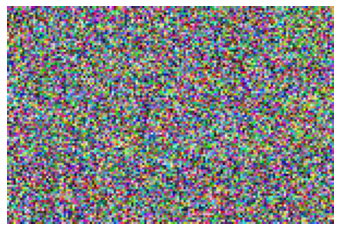

In [15]:
import matplotlib.pyplot as plt

# Assuming best_individual contains the pixel values of the best image
# Display the image using Matplotlib
plt.imshow(best_individual)
plt.axis('off')  # Turn off axis labels
plt.show()

In [18]:
import numpy as np
import random
from PIL import Image
from skimage.color import deltaE_cie76, rgb2lab
from copy import copy
from operator import attrgetter
from random import choice

class Individual:
    def __init__(self, representation=None):
        self.representation = representation
        self.fitness = self.get_fitness()

    def get_fitness(self):
        raise NotImplementedError("You need to implement the get_fitness method.")

class ColorIndividual(Individual):
    def __init__(self, representation, target_array):
        self.representation = representation
        self.target_array = target_array
        self.array = self.representation  # Assuming self.array is a representation of the image
        self.fitness = self.get_fitness_euclidean(target_array)

    def get_fitness_euclidean(self, target_array):
        # Convert RGB images to Lab color space for better perceptual accuracy
        target_lab = rgb2lab(target_array)
        array_lab = rgb2lab(self.array)
        diff_array = deltaE_cie76(target_lab, array_lab)
        self.fitness = np.mean(diff_array)
        return self.fitness

def gaussian_mutation(individual, mutation_rate, sigma):
    mutated_repr = individual.representation.copy()
    for i in range(mutated_repr.shape[0]):
        for j in range(mutated_repr.shape[1]):
            if random.random() < mutation_rate:
                # Sample changes from a Gaussian distribution
                delta = np.random.normal(scale=sigma, size=3)
                mutated_repr[i, j] = np.clip(mutated_repr[i, j] + delta, 0, 255)
    return ColorIndividual(mutated_repr, individual.target_array)

def crossover(parent1_repr, parent2_repr):
    point = random.randint(0, parent1_repr.shape[0] - 1)
    child1_repr = np.concatenate((parent1_repr[:point], parent2_repr[point:]), axis=0)
    child2_repr = np.concatenate((parent2_repr[:point], parent1_repr[point:]), axis=0)
    return child1_repr, child2_repr

class Population:
    def __init__(self, size, optim):
        self.size = size
        self.optim = optim
        self.individuals = []

    def evolve(self, gens, xo_prob, mut_prob, select, xo, mutate, elitism):
        for i in range(gens):
            new_pop = []
            if elitism:
                elite = copy(min(self.individuals, key=attrgetter('fitness')))

            while len(new_pop) < self.size:
                parent1, parent2 = select(self), select(self)
                if random.random() < xo_prob:
                    offspring1_repr, offspring2_repr = xo(parent1.representation, parent2.representation)
                else:
                    offspring1_repr, offspring2_repr = parent1.representation, parent2.representation

                if random.random() < mut_prob:
                    offspring1_repr = mutate(ColorIndividual(representation=offspring1_repr, target_array=target_array), mut_prob, sigma=20).representation
                if random.random() < mut_prob:
                    offspring2_repr = mutate(ColorIndividual(representation=offspring2_repr, target_array=target_array), mut_prob, sigma=20).representation

                new_pop.append(ColorIndividual(representation=offspring1_repr, target_array=target_array))
                if len(new_pop) < self.size:
                    new_pop.append(ColorIndividual(representation=offspring2_repr, target_array=target_array))

            if elitism:
                worst = max(new_pop, key=attrgetter('fitness'))
                if elite.fitness < worst.fitness:
                    new_pop.pop(new_pop.index(worst))
                    new_pop.append(elite)

            self.individuals = new_pop
            print(f"Best fitness of gen #{i + 1}: {min(self.individuals, key=attrgetter('fitness')).fitness}")

    def __len__(self):
        return len(self.individuals)

    def __getitem__(self, position):
        return self.individuals[position]

class ColorPopulation(Population):
    def __init__(self, size, optim, target_array, **kwargs):
        super().__init__(size, optim)
        self.target_array = target_array
        self.individuals = [ColorIndividual(representation=np.random.randint(0, 256, target_array.shape, dtype=np.uint8), target_array=target_array) for _ in range(size)]

# Create a population
population_size = 100
mutation_rate = 0.01
generations = 1000
xo_prob = 0.7
elitism = True

population = ColorPopulation(size=population_size, optim="min", target_array=target_array)

def tournament_sel(population, tour_size=3):
    tournament = [choice(population) for _ in range(tour_size)]
    return min(tournament, key=attrgetter('fitness'))

def selection(pop):
    return tournament_sel(pop, tour_size=3)

population.evolve(
    gens=generations,
    xo_prob=xo_prob,
    mut_prob=mutation_rate,
    select=selection,
    xo=crossover,
    mutate=lambda ind, mut_rate, sigma: gaussian_mutation(ind, mut_rate, sigma),
    elitism=elitism
)

best_individual = min(population.individuals, key=attrgetter('fitness')).representation
best_image = Image.fromarray(best_individual)


Best fitness of gen #1: 71.77605529572533
Best fitness of gen #2: 71.5005685202055
Best fitness of gen #3: 71.42636059491295
Best fitness of gen #4: 71.11937885611044
Best fitness of gen #5: 71.07922316111
Best fitness of gen #6: 71.04656295458001
Best fitness of gen #7: 71.00492082776026
Best fitness of gen #8: 70.92992087782373
Best fitness of gen #9: 70.86141325919577
Best fitness of gen #10: 70.74160428545842
Best fitness of gen #11: 70.71017030174369
Best fitness of gen #12: 70.66535471437189
Best fitness of gen #13: 70.62529397365373
Best fitness of gen #14: 70.61117129321275
Best fitness of gen #15: 70.56085447392523
Best fitness of gen #16: 70.54634979222844
Best fitness of gen #17: 70.5238580059968
Best fitness of gen #18: 70.51503437819781
Best fitness of gen #19: 70.47522204870324
Best fitness of gen #20: 70.43703830595578
Best fitness of gen #21: 70.40364837844149
Best fitness of gen #22: 70.38985916162234
Best fitness of gen #23: 70.35199728170562
Best fitness of gen #24: 

Best fitness of gen #191: 69.96872355426747
Best fitness of gen #192: 69.96872355426747
Best fitness of gen #193: 69.96783959759328
Best fitness of gen #194: 69.96535770826276
Best fitness of gen #195: 69.9632533214188
Best fitness of gen #196: 69.9623160795063
Best fitness of gen #197: 69.95978652832002
Best fitness of gen #198: 69.95749475757621
Best fitness of gen #199: 69.95567204483604
Best fitness of gen #200: 69.95141085675282
Best fitness of gen #201: 69.94865078862225
Best fitness of gen #202: 69.94557806675974
Best fitness of gen #203: 69.94557806675974
Best fitness of gen #204: 69.94416085587005
Best fitness of gen #205: 69.93934172520237
Best fitness of gen #206: 69.93934172520237
Best fitness of gen #207: 69.93756216905965
Best fitness of gen #208: 69.9359693002026
Best fitness of gen #209: 69.93531695902239
Best fitness of gen #210: 69.93070746212497
Best fitness of gen #211: 69.92996084998275
Best fitness of gen #212: 69.92996084998275
Best fitness of gen #213: 69.929177

Best fitness of gen #378: 69.62661491967185
Best fitness of gen #379: 69.62661491967185
Best fitness of gen #380: 69.62643048232192
Best fitness of gen #381: 69.62296432624969
Best fitness of gen #382: 69.62296432624969
Best fitness of gen #383: 69.62007961338234
Best fitness of gen #384: 69.61891079295248
Best fitness of gen #385: 69.61532318174731
Best fitness of gen #386: 69.61532318174731
Best fitness of gen #387: 69.61398734963845
Best fitness of gen #388: 69.60763734099258
Best fitness of gen #389: 69.60491958107895
Best fitness of gen #390: 69.60491958107895
Best fitness of gen #391: 69.60446102008923
Best fitness of gen #392: 69.60446102008923
Best fitness of gen #393: 69.6017432601756
Best fitness of gen #394: 69.60020767138732
Best fitness of gen #395: 69.59635613596669
Best fitness of gen #396: 69.59579196749935
Best fitness of gen #397: 69.59495307085191
Best fitness of gen #398: 69.58610881292044
Best fitness of gen #399: 69.58495011272458
Best fitness of gen #400: 69.5808

Best fitness of gen #565: 69.20533128161046
Best fitness of gen #566: 69.20449299983552
Best fitness of gen #567: 69.20374542660335
Best fitness of gen #568: 69.20327558137916
Best fitness of gen #569: 69.20279967392547
Best fitness of gen #570: 69.20279967392547
Best fitness of gen #571: 69.20279967392547
Best fitness of gen #572: 69.20279967392547
Best fitness of gen #573: 69.1986328843904
Best fitness of gen #574: 69.1960229857839
Best fitness of gen #575: 69.19330087884835
Best fitness of gen #576: 69.19330087884835
Best fitness of gen #577: 69.19308933731945
Best fitness of gen #578: 69.19057168398302
Best fitness of gen #579: 69.1901974182188
Best fitness of gen #580: 69.18700424348643
Best fitness of gen #581: 69.18392233367004
Best fitness of gen #582: 69.17685765761675
Best fitness of gen #583: 69.17685765761675
Best fitness of gen #584: 69.17436494596286
Best fitness of gen #585: 69.17386921684025
Best fitness of gen #586: 69.17202959358525
Best fitness of gen #587: 69.171289

Best fitness of gen #753: 68.85223585492429
Best fitness of gen #754: 68.85103673499604
Best fitness of gen #755: 68.85103673499604
Best fitness of gen #756: 68.84782141233673
Best fitness of gen #757: 68.84782141233673
Best fitness of gen #758: 68.8420933053931
Best fitness of gen #759: 68.84198282914214
Best fitness of gen #760: 68.84101792001124
Best fitness of gen #761: 68.83825783301955
Best fitness of gen #762: 68.8363937378786
Best fitness of gen #763: 68.83383962783924
Best fitness of gen #764: 68.83010479991665
Best fitness of gen #765: 68.82637413143668
Best fitness of gen #766: 68.82582106929048
Best fitness of gen #767: 68.82137653471978
Best fitness of gen #768: 68.82011052171246
Best fitness of gen #769: 68.81797799765307
Best fitness of gen #770: 68.81640165271342
Best fitness of gen #771: 68.81429512126013
Best fitness of gen #772: 68.81183123693896
Best fitness of gen #773: 68.81041869046456
Best fitness of gen #774: 68.80894967225917
Best fitness of gen #775: 68.80584

Best fitness of gen #940: 68.499965919762
Best fitness of gen #941: 68.49915451315691
Best fitness of gen #942: 68.49866583411229
Best fitness of gen #943: 68.49797351155739
Best fitness of gen #944: 68.49708206238584
Best fitness of gen #945: 68.49701209712364
Best fitness of gen #946: 68.49227901607503
Best fitness of gen #947: 68.491665833937
Best fitness of gen #948: 68.4876445475709
Best fitness of gen #949: 68.484671492566
Best fitness of gen #950: 68.47883618129498
Best fitness of gen #951: 68.47535569140271
Best fitness of gen #952: 68.47535569140271
Best fitness of gen #953: 68.46147465886965
Best fitness of gen #954: 68.46147465886965
Best fitness of gen #955: 68.45940332365865
Best fitness of gen #956: 68.45940332365865
Best fitness of gen #957: 68.45880008920228
Best fitness of gen #958: 68.454147606721
Best fitness of gen #959: 68.454147606721
Best fitness of gen #960: 68.45308061661079
Best fitness of gen #961: 68.45308061661079
Best fitness of gen #962: 68.45192271209297

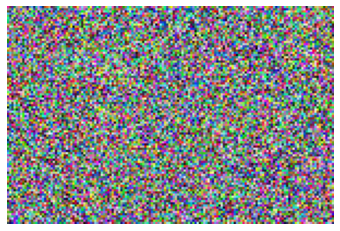

In [19]:
import matplotlib.pyplot as plt

# Assuming best_individual contains the pixel values of the best image
# Display the image using Matplotlib
plt.imshow(best_individual)
plt.axis('off')  # Turn off axis labels
plt.show()

In [25]:
import numpy as np
import random
from PIL import Image, ImageDraw
from skimage.color import deltaE_cie76, rgb2lab
from copy import deepcopy, copy
from operator import attrgetter

class Individual:
    def __init__(self, representation=None):
        self.representation = representation
        self.fitness = self.get_fitness()

    def get_fitness(self):
        raise NotImplementedError("You need to implement the get_fitness method.")

class Triangle:
    def __init__(self, img_width, img_height):
        self._img_width = img_width
        self._img_height = img_height
        x = random.randint(0, int(img_width))
        y = random.randint(0, int(img_height))

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = (
            random.randint(0, 256),
            random.randint(0, 256),
            random.randint(0, 256),
            random.randint(0, 256)
        )

    def mutate(self, sigma=1.0):
        mutations = ['shift', 'point', 'color', 'reset']
        weights = [30, 35, 30, 5]
        mutation_type = random.choices(mutations, weights=weights, k=1)[0]

        if mutation_type == 'shift':
            x_shift = int(random.randint(-50, 50) * sigma)
            y_shift = int(random.randint(-50, 50) * sigma)
            self.points = [(x + x_shift, y + y_shift) for x, y in self.points]
        elif mutation_type == 'point':
            index = random.choice(list(range(len(self.points))))
            self.points[index] = (
                self.points[index][0] + int(random.randint(-50, 50) * sigma),
                self.points[index][1] + int(random.randint(-50, 50) * sigma),
            )
        elif mutation_type == 'color':
            self.color = tuple(
                c + int(random.randint(-50, 50) * sigma) for c in self.color
            )
            self.color = tuple(
                min(max(c, 0), 255) for c in self.color
            )
        else:
            new_triangle = Triangle(self._img_width, self._img_height)
            self.points = new_triangle.points
            self.color = new_triangle.color

class ColorIndividual(Individual):
    def __init__(self, representation=None, target_array=None, num_triangles=50):
        self.target_array = target_array
        self.num_triangles = num_triangles

        if representation is None:
            self.representation = {
                'pixels': np.random.randint(0, 256, target_array.shape, dtype=np.uint8),
                'triangles': [Triangle(target_array.shape[1], target_array.shape[0]) for _ in range(num_triangles)]
            }
        else:
            self.representation = representation
        
        self.array = self.render_image()
        self.fitness = self.get_fitness_euclidean()

    def render_image(self):
        image = Image.fromarray(self.representation['pixels'])
        draw = ImageDraw.Draw(image, "RGBA")

        for triangle in self.representation['triangles']:
            draw.polygon(triangle.points, fill=triangle.color)

        return np.array(image)

    def get_fitness_euclidean(self):
        target_lab = rgb2lab(self.target_array)
        array_lab = rgb2lab(self.array)
        diff_array = deltaE_cie76(target_lab, array_lab)
        self.fitness = np.mean(diff_array)
        return self.fitness

def mutation(individual, mutation_rate):
    mutated_repr = deepcopy(individual.representation)
    
    # Mutate pixels
    if random.random() < mutation_rate:
        for i in range(mutated_repr['pixels'].shape[0]):
            for j in range(mutated_repr['pixels'].shape[1]):
                if random.random() < mutation_rate:
                    shift = np.random.randint(-20, 20, 3)
                    mutated_repr['pixels'][i, j] = np.clip(mutated_repr['pixels'][i, j] + shift, 0, 255)

    # Mutate triangles
    for triangle in mutated_repr['triangles']:
        if random.random() < mutation_rate:
            triangle.mutate()

    return ColorIndividual(representation=mutated_repr, target_array=individual.target_array)

def crossover(parent1_repr, parent2_repr):
    child1_repr = deepcopy(parent1_repr)
    child2_repr = deepcopy(parent2_repr)

    # Crossover pixels
    point = random.randint(0, parent1_repr['pixels'].shape[0] - 1)
    child1_repr['pixels'][:point], child2_repr['pixels'][:point] = parent2_repr['pixels'][:point], parent1_repr['pixels'][:point]

    # Crossover triangles
    for i in range(len(parent1_repr['triangles'])):
        if random.random() < 0.5:
            child1_repr['triangles'][i], child2_repr['triangles'][i] = parent2_repr['triangles'][i], parent1_repr['triangles'][i]

    return child1_repr, child2_repr

class Population:
    def __init__(self, size, optim):
        self.size = size
        self.optim = optim
        self.individuals = []

    def evolve(self, gens, xo_prob, mut_prob, select, xo, mutate, elitism):
        for i in range(gens):
            new_pop = []
            if elitism:
                elite = copy(min(self.individuals, key=attrgetter('fitness')))

            while len(new_pop) < self.size:
                parent1, parent2 = select(self), select(self)
                if random.random() < xo_prob:
                    offspring1_repr, offspring2_repr = xo(parent1.representation, parent2.representation)
                else:
                    offspring1_repr, offspring2_repr = parent1.representation, parent2.representation

                if random.random() < mut_prob:
                    offspring1_repr = mutate(ColorIndividual(representation=offspring1_repr, target_array=target_array), mut_prob).representation
                if random.random() < mut_prob:
                    offspring2_repr = mutate(ColorIndividual(representation=offspring2_repr, target_array=target_array), mut_prob).representation

                new_pop.append(ColorIndividual(representation=offspring1_repr, target_array=target_array))
                if len(new_pop) < self.size:
                    new_pop.append(ColorIndividual(representation=offspring2_repr, target_array=target_array))

            if elitism:
                worst = max(new_pop, key=attrgetter('fitness'))
                if elite.fitness < worst.fitness:
                    new_pop.pop(new_pop.index(worst))
                    new_pop.append(elite)

            self.individuals = new_pop
            print(f"Best fitness of gen #{i + 1}: {min(self.individuals, key=attrgetter('fitness')).fitness}")

    def __len__(self):
        return len(self.individuals)

    def __getitem__(self, position):
        return self.individuals[position]

class ColorPopulation(Population):
    def __init__(self, size, optim, target_array, num_triangles=50, **kwargs):
        super().__init__(size, optim)
        self.target_array = target_array
        self.individuals = [ColorIndividual(target_array=target_array, num_triangles=num_triangles) for _ in range(size)]

# Load target image
target_image = Image.open('target_image.jpg').convert('RGB')
target_array = np.array(target_image)

# Create a population
population_size = 100
mutation_rate = 0.01
generations = 1000
xo_prob = 0.7
elitism = True

population = ColorPopulation(size=population_size, optim="min", target_array=target_array, num_triangles=50)

def tournament_sel(population, tour_size=3):
    tournament = [random.choice(population) for _ in range(tour_size)]
    return min(tournament, key=attrgetter('fitness'))

def selection(pop):
    return tournament_sel(pop, tour_size=3)

population.evolve(
    gens=generations,
    xo_prob=xo_prob,
    mut_prob=mutation_rate,
    select=selection,
    xo=crossover,
    mutate=lambda ind, mut_rate: mutation(ind, mut_rate),
    elitism=elitism
)

best_individual = min(population.individuals, key=attrgetter('fitness')).representation
best_image = Image.fromarray(best_individual['pixels'])
draw = ImageDraw.Draw(best_image, "RGBA")

for triangle in best_individual['triangles']:
    draw.polygon(triangle.points, fill=triangle.color)


Best fitness of gen #1: 68.95164765863811
Best fitness of gen #2: 68.81239885999302
Best fitness of gen #3: 68.25515306232276
Best fitness of gen #4: 67.77919985262487
Best fitness of gen #5: 66.41868573034834
Best fitness of gen #6: 66.41868573034834
Best fitness of gen #7: 66.41868573034834
Best fitness of gen #8: 65.69245651861746
Best fitness of gen #9: 65.51957168519009
Best fitness of gen #10: 65.00596350307994
Best fitness of gen #11: 64.5618587352395
Best fitness of gen #12: 64.46786257016684
Best fitness of gen #13: 64.1595008811054
Best fitness of gen #14: 63.85491072084982
Best fitness of gen #15: 63.65122790839471
Best fitness of gen #16: 63.08867238495893
Best fitness of gen #17: 62.93772662872897
Best fitness of gen #18: 62.736233700614314
Best fitness of gen #19: 62.43820231452323
Best fitness of gen #20: 62.43820231452323
Best fitness of gen #21: 62.04035842317217
Best fitness of gen #22: 61.78823594768637
Best fitness of gen #23: 61.740626649456104
Best fitness of gen 

Best fitness of gen #189: 59.38299096057141
Best fitness of gen #190: 59.38299096057141
Best fitness of gen #191: 59.38299096057141
Best fitness of gen #192: 59.38299096057141
Best fitness of gen #193: 59.38299096057141
Best fitness of gen #194: 59.21284642344876
Best fitness of gen #195: 59.21284642344876
Best fitness of gen #196: 59.21284642344876
Best fitness of gen #197: 59.21284642344876
Best fitness of gen #198: 59.1994609873019
Best fitness of gen #199: 59.1994609873019
Best fitness of gen #200: 59.1994609873019
Best fitness of gen #201: 59.188431764053966
Best fitness of gen #202: 59.188431764053966
Best fitness of gen #203: 59.188431764053966
Best fitness of gen #204: 59.188431764053966
Best fitness of gen #205: 59.188431764053966
Best fitness of gen #206: 59.188431764053966
Best fitness of gen #207: 59.188431764053966
Best fitness of gen #208: 59.188431764053966
Best fitness of gen #209: 59.188431764053966
Best fitness of gen #210: 59.187271985730035
Best fitness of gen #211:

Best fitness of gen #375: 56.78467918592998
Best fitness of gen #376: 56.78467918592998
Best fitness of gen #377: 56.78467918592998
Best fitness of gen #378: 56.78467918592998
Best fitness of gen #379: 56.78467918592998
Best fitness of gen #380: 56.78467918592998
Best fitness of gen #381: 56.78467918592998
Best fitness of gen #382: 56.78467918592998
Best fitness of gen #383: 56.78467918592998
Best fitness of gen #384: 56.78467918592998
Best fitness of gen #385: 56.78467918592998
Best fitness of gen #386: 56.78467918592998
Best fitness of gen #387: 56.78467918592998
Best fitness of gen #388: 56.78467918592998
Best fitness of gen #389: 56.60680535452975
Best fitness of gen #390: 56.60680535452975
Best fitness of gen #391: 56.60680535452975
Best fitness of gen #392: 56.574512654398156
Best fitness of gen #393: 56.574512654398156
Best fitness of gen #394: 56.574512654398156
Best fitness of gen #395: 56.574512654398156
Best fitness of gen #396: 56.574512654398156
Best fitness of gen #397: 5

Best fitness of gen #560: 54.96144784739592
Best fitness of gen #561: 54.96144784739592
Best fitness of gen #562: 54.96144784739592
Best fitness of gen #563: 54.96144784739592
Best fitness of gen #564: 54.96144784739592
Best fitness of gen #565: 54.96144784739592
Best fitness of gen #566: 54.96144784739592
Best fitness of gen #567: 54.96144784739592
Best fitness of gen #568: 54.96144784739592
Best fitness of gen #569: 54.96144784739592
Best fitness of gen #570: 54.95385493363871
Best fitness of gen #571: 54.8486580607665
Best fitness of gen #572: 54.8486580607665
Best fitness of gen #573: 54.8486580607665
Best fitness of gen #574: 54.8486580607665
Best fitness of gen #575: 54.841065147009296
Best fitness of gen #576: 54.841065147009296
Best fitness of gen #577: 54.841065147009296
Best fitness of gen #578: 54.82964908672694
Best fitness of gen #579: 54.82205617296973
Best fitness of gen #580: 54.82205617296973
Best fitness of gen #581: 54.82205617296973
Best fitness of gen #582: 54.8175

Best fitness of gen #748: 51.982795137851745
Best fitness of gen #749: 51.982795137851745
Best fitness of gen #750: 51.982795137851745
Best fitness of gen #751: 51.982795137851745
Best fitness of gen #752: 51.982795137851745
Best fitness of gen #753: 51.982795137851745
Best fitness of gen #754: 51.982795137851745
Best fitness of gen #755: 51.982795137851745
Best fitness of gen #756: 51.982795137851745
Best fitness of gen #757: 51.982795137851745
Best fitness of gen #758: 51.982795137851745
Best fitness of gen #759: 51.93572133386177
Best fitness of gen #760: 51.93572133386177
Best fitness of gen #761: 51.93572133386177
Best fitness of gen #762: 51.93572133386177
Best fitness of gen #763: 51.93572133386177
Best fitness of gen #764: 51.93572133386177
Best fitness of gen #765: 51.93572133386177
Best fitness of gen #766: 51.93572133386177
Best fitness of gen #767: 51.93572133386177
Best fitness of gen #768: 51.93572133386177
Best fitness of gen #769: 51.93572133386177
Best fitness of gen #

Best fitness of gen #934: 50.389668585408174
Best fitness of gen #935: 50.389668585408174
Best fitness of gen #936: 50.389668585408174
Best fitness of gen #937: 50.389668585408174
Best fitness of gen #938: 50.389668585408174
Best fitness of gen #939: 50.389668585408174
Best fitness of gen #940: 50.389668585408174
Best fitness of gen #941: 50.389668585408174
Best fitness of gen #942: 50.389668585408174
Best fitness of gen #943: 50.389668585408174
Best fitness of gen #944: 50.389668585408174
Best fitness of gen #945: 50.389668585408174
Best fitness of gen #946: 50.35716515362997
Best fitness of gen #947: 50.35716515362997
Best fitness of gen #948: 50.35716515362997
Best fitness of gen #949: 50.33074658530487
Best fitness of gen #950: 50.33074658530487
Best fitness of gen #951: 50.33074658530487
Best fitness of gen #952: 50.27620482343489
Best fitness of gen #953: 50.249786255109804
Best fitness of gen #954: 50.249786255109804
Best fitness of gen #955: 50.249786255109804
Best fitness of g

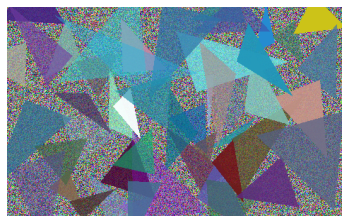

In [28]:
best_image_array = np.array(best_image)
plt.imshow(best_image_array)
plt.axis('off')  # Turn off axis labels
plt.show()